In [1]:
import matplotlib.pyplot as plt
from numpy import *
import numpy as np
from scipy.constants import c, pi
import scipy.special as sc
from diffraction import length, unit, D_s_h

In [63]:
class Wave:
    def __init__(self, f=1e9):
        self.f = f
        self.l = c / self.f
        self.k = 2 * pi / self.l


class Edge:
    def __init__(self, direction, normals):
        self.normals = np.asarray(normals, dtype=float)
        self.direction = np.asarray(direction, dtype=float)
        self.angle = pi - arccos(dot(self.normals[0, :], self.normals[1, :]))


class Vector:
    def __init__(self, vector):
        self.vector = np.asarray(vector, dtype=float)
        self.len = np.linalg.norm(self.vector)
        self.direction = self.vector / self.len


def unit(vector):
    return Vector(vector).direction


def diffract(field, path, edge, wave):
    S = path[0, :]
    D = path[1, :]
    O = path[2, :]

    k = wave.k
    alpha = edge.angle
    e = edge.direction

    s_i = Vector(D - S)
    s_d = Vector(O - D)
    
    # TODO: remove
    theta = np.arctan2(path[2, -1], path[2, 0])

    n = (2 * pi - alpha) / pi
    beta_0 = arcsin(np.linalg.norm(cross(s_i.direction, e)))

    if dot(s_i.direction, -edge.normals[0]) >= dot(s_i.direction, -edge.normals[1]):
        n_o = edge.normals[0]  # Normal to outer surface
    else:
        n_o = edge.normals[1]

    phi_i = unit(-cross(e, s_i.direction))
    beta_0_i = unit(+cross(phi_i, s_i.direction))

    phi_d = unit(cross(e, s_d.direction))
    beta_0_d = unit(cross(phi_d, s_d.direction))

    s_t_i = unit(s_i.direction - dot(s_i.direction, e) * e)
    s_t_d = unit(s_d.direction - dot(s_d.direction, e) * e)

    t = cross(n_o, e)

    phi_i_angle = pi - (pi - arccos(dot(-s_t_i, t))) * sign(dot(-s_t_i, n_o))
    phi_d_angle = pi - (pi - arccos(dot(+s_t_d, t))) * sign(dot(+s_t_d, n_o))
    
    # Diffraction

    Li = Lro = Lrn = s_d.len * sin(beta_0) ** 2

    D_s, D_h = D_s_h(n, k, beta_0, phi_d_angle, phi_i_angle, Li, Lrn, Lro)
    

    Ei = array([dot(field, beta_0_i), dot(field, phi_i)])

    D = array([[-D_s, 0], [0, -D_h]], dtype=complex64)

    rho = s_i.len
    s = s_d.len
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)

    Ed = factor * (D @ Ei)

    return Ed[0] * beta_0_d + Ed[1] * phi_d

def Evector(theta, r=1e6, f=1e9):
    wave = Wave(f)
    
    k = wave.k
    
    los = 1 * (theta <= pi / 2)
    ejkr_r = exp(-1j * k * r) / r  # Path loss
    theta_dir = array([cos(theta), 0, -sin(theta)])
    E = los * sin(theta) * ejkr_r * theta_dir

    O = array([0, 0, 0], dtype=float)  # TX point
    P = array([r * sin(theta), 0, r * cos(theta)], dtype=float)  # RX point
    
    a = 3 * wave.l

    for x in [+a, -a]:
        Q = array([x, 0, 0], dtype=float)  # Where diffraction occurs
        
        path = np.row_stack([O, Q, P])
        edge = Edge(sign(x) * array([0, 1, 0], dtype=float), [[0, 0, +1], [0, 0, -1]])

        alpha = np.arctan2(x, 0)

        theta_dir = array([cos(alpha), 0, -sin(alpha)])

        field = sin(alpha) * (exp(-1j * k * a) / a) * theta_dir
        
        E += diffract(field, path, edge, wave)
        
    return E

In [64]:
def rotate(E, u, v, up, vp):
    field = E[0] * u + E[1] * v
    return array([dot(up, field), dot(vp, field)])


def sign(x):
    if x < 0:
        return -1
    else:
        return 1


def E(theta, r=1e6, f=1e9):

    # Wave constants
    l = c / f
    k = 2 * pi / l
    a = 3 * l

    # LOS contribution
    los = 1 * (theta <= pi / 2)
    ejkr_r = exp(-1j * k * r) / r  # Path loss

    theta_dir = array([cos(theta), 0, -sin(theta)])

    E = 1 * los * sin(theta) * ejkr_r * theta_dir

    # Diffraction constant parameters
    n = 2  # because alpha = 0
    beta_0 = pi / 2

    O = array([0, 0, 0], dtype=float)  # TX point
    P = array([r * sin(theta), 0, r * cos(theta)], dtype=float)  # RX point

    for x in [+a, -a]:
        Q = array([x, 0, 0], dtype=float)  # Where diffraction occurs

        alpha = np.arctan2(x, 0)

        theta_dir = array([cos(alpha), 0, -sin(alpha)])

        E_D = sin(alpha) * (exp(-1j * k * a) / a) * theta_dir

        e = sign(x) * array([0, 1, 0], dtype=float)  # Edge direction
        n0 = array([0, 0, +1], dtype=float)  # Normal direction

        s_dir = unit(P - Q)
        s = length(P - Q)
        s_p_dir = unit(Q - O)

        sinb01 = np.linalg.norm(cross(s_p_dir, e))
        sinb02 = np.linalg.norm(cross(s_dir, e))
        assert (
            abs(sinb01 - sinb02) < 1e-6
        ), f"KELLER Cone is not satisfied with {sinb01} and {sinb02}"

        phi_p_dir = unit(-cross(e, s_p_dir))
        beta_0_p_dir = unit(+cross(phi_p_dir, s_p_dir))

        phi_dir = unit(cross(e, s_dir))
        beta_0_dir = unit(cross(phi_dir, s_dir))

        s_t_dir = unit(s_dir - dot(s_dir, e) * e)
        s_t_p_dir = unit(s_p_dir - dot(s_p_dir, e) * e)

        t = cross(n0, e)

        # print(dot(-s_t_p_dir, t), dot(-s_t_p_dir, n0), sign(dot(-s_t_p_dir, n0)))
        phi_p = pi - (pi - arccos(dot(-s_t_p_dir, t))) * sign(dot(-s_t_p_dir, n0))
        phi = pi - (pi - arccos(dot(s_t_dir, t))) * sign(dot(s_t_dir, n0))

        # Diffraction
        # phi_p = 0
        Li = Lro = Lrn = a
        # print(phi, phi_p)
        D_s, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)

        Ei = array([dot(E_D, beta_0_p_dir), dot(E_D, phi_p_dir)])

        D = 0.5 * array([[-D_s, 0], [0, -D_h]], dtype=complex64)

        rho = complex(x / sin(theta))
        factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)

        Ed = factor * (D @ Ei)

        E += Ed[0] * beta_0_dir + Ed[1] * phi_dir

    return E

<Figure size 720x504 with 0 Axes>

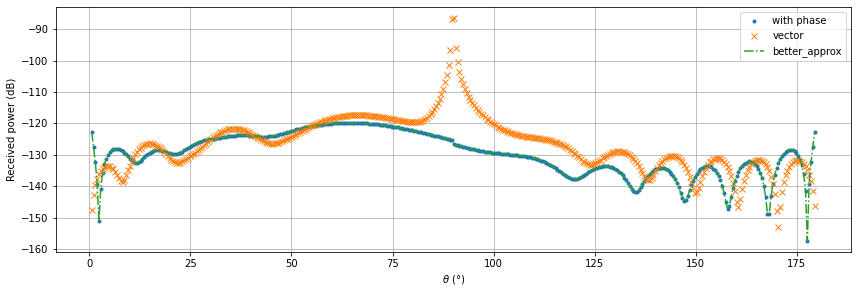

In [65]:
n = 400

theta = np.linspace(0.01, pi - 0.01, n)

plt.figure(figsize=(10, 7))

E2 = np.zeros((n, 3), dtype=np.complex64)
Ev = np.zeros((n, 3), dtype=np.complex64)

for i in range(n):
    E2[i, :] = E(theta[i], r=1e6)
    
    Ev[i, :] = Evector(theta[i], r=1e6)


# for t in theta:


# E = Et(theta, r)
Pbis = 20 * np.log10(np.linalg.norm(E2, axis=1))
Pv = 20 * np.log10(np.linalg.norm(Ev, axis=1))
# Pbis = Pbis - np.max(Pbis)
plt.figure(figsize=(28.5 / 2, 9 / 2))
plt.plot(np.rad2deg(theta), Pbis, ".", label="with phase")
plt.plot(np.rad2deg(theta), Pv, "x", label="vector")
# plt.plot(np.rad2deg(theta), np.loadtxt("P1.txt"), "-.", label="approx")
plt.plot(np.rad2deg(theta), np.loadtxt("P3.txt"), "-.", label="better_approx")
plt.xlabel(r"$\theta$ (°)")
plt.ylabel(r"Received power (dB)")
plt.legend()
plt.grid("on")


In [53]:
np.ones((4, 3))[0]

array([1., 1., 1.])